In [ ]:
# ignore pandas warnings
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from onestop.linear_mm_utils.calc_means_main import calc_mm_means_for_all_outcomes
from onestop.linear_mm_utils.julia_linear_mm import run_linear_mm
from plotly.subplots import make_subplots
from constants import (
    all_outcomes,
    colors,
    outcome_name_mapping,
    re_columns,
    IA_REPORT_PATH,
)
from process_IA_rep_for_reread_analysis import (
    process_df_for_reread_analysis,
    upload,
)
from pygam import LinearGAM, GAM
from scipy.stats import ttest_ind
from statsmodels.api import OLS, add_constant
from statsmodels.formula.api import ols
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [5]:
data = pd.read_csv(
    "../" + IA_REPORT_PATH,
    engine="pyarrow",
)
# remove all columns with _Surprisal in them except for gpt2_Surprisal and prev_gpt2_Surprisal
cols_to_keep = ["gpt2_Surprisal", "prev_gpt2_Surprisal"]
cols_to_drop = [
    col for col in data.columns if "_Surprisal" in col and col not in cols_to_keep
]
data = data.drop(columns=cols_to_drop)

et_data_enriched = process_df_for_reread_analysis(data=data).query(
    "IA_DWELL_TIME < 10000"
)

Exclude IAs
Adding paragraph_length column...
Splitting unique_paragraph_id to original columns
Adding add_first_read_out_of_2_column indicator column...
Adding experiment_IA_numbering indicator column...
Adding paragraph_numbering column...
Adding article_ind_diff_from_first_reading column for articles 11 and 12...
Adding variables indicating rereading trials with the same / different critical span as in the first reading


In [6]:
personal_RT_FR = (
    et_data_enriched.query("article_ind <= 10")
    .groupby("subject_id")[["IA_DWELL_TIME"]]
    .mean()
    .reset_index()
    .rename(columns={"IA_DWELL_TIME": "PERSONAL_FR_IA_DWELL_TIME"})
)

# Add PERSONAL_FR_IA_DWELL_TIME to et_data_enriched as sub_FR_mean_RT
et_data_enriched = et_data_enriched.merge(
    personal_RT_FR[["subject_id", "PERSONAL_FR_IA_DWELL_TIME"]], on="subject_id"
)
et_data_enriched = et_data_enriched.rename(
    columns={"PERSONAL_FR_IA_DWELL_TIME": "sub_FR_mean_RT"}
)

FR_RR_compre_scores = (
    et_data_enriched[["subject_id", "unique_paragraph_id", "reread", "is_correct"]]
    .drop_duplicates()
    .groupby(["subject_id", "reread"])
    .apply(lambda x: x["is_correct"].mean())
    .rename("comp_score_by_RR")
    .reset_index()
)

et_data_enriched = pd.merge(
    et_data_enriched,
    FR_RR_compre_scores.query("reread == 0").drop(columns=["reread"]),
    on="subject_id",
)
# rename comp_score_by_RR to comp_score_by_FR
et_data_enriched = et_data_enriched.rename(
    columns={"comp_score_by_RR": "sub_comp_score_FR"}
)

/tmp/ipykernel_1702441/138465948.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["is_correct"].mean())


### Comprehension Accuracy ~ reread & has_preview

The reading comprehension accuracy in the regular trials is 86.9% in the Hunting condition and 81.1% in the Gathering
condition, which is lower (p < 10−??)2. The reading comprehension accuracy in the repeated reading trials is 90.6% in the
Hunting condition and 84.2% in the Gathering condition, which is higher than in the regular trials in both regimes (p < 10−??).


In [7]:
et_data_enriched["unique_q_id"] = (
    et_data_enriched["batch"].astype(str)
    + "_"
    + et_data_enriched["article_id"].astype(str)
    + "_"
    + et_data_enriched["paragraph_id"].astype(str)
    + "_"
    + et_data_enriched["q_ind"].astype(str)
)

In [8]:
_ = run_linear_mm(
    df_input=et_data_enriched[
        ["subject_id", "has_preview", "reread", "is_correct", "unique_q_id"]
    ]
    .drop_duplicates()
    .replace({"Hunting": 1, "Gathering": 0}),
    outcome_variable="is_correct",
    re_cols=["subject_id", "unique_q_id"],
    formula="is_correct ~ reread + has_preview + reread & has_preview + (reread + has_preview + reread & has_preview | subject_id) + (reread + has_preview + reread & has_preview | unique_q_id)",
)

Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + reread + has_preview + reread & has_preview + (1 + reread + has_preview + reread & has_preview | subject_id) + (1 + reread + has_preview + reread & has_preview | unique_q_id)
   logLik   -2 logLik     AIC       AICc        BIC    
 -7895.3325 15790.6649 15840.6649 15840.7209 16041.9895

Variance components:
                   Column         Variance  Std.Dev.   Corr.
unique_q_id (Intercept)           0.0225714 0.1502379
            reread                0.0080009 0.0894477 -0.37
            has_preview           0.0071463 0.0845356 -0.63 +0.34
            reread & has_preview  0.0045534 0.0674786 +0.08 -0.94 -0.31
subject_id  (Intercept)           0.0057603 0.0758963
            reread                0.0005889 0.0242676 +0.08
            has_preview           0.0022429 0.0473591 -0.66 -0.42
            reread & has_preview  0.0007045 0.0265420 -0.61 -0.74 +0.41
Residual                          0.1069398 0.3270165
 Number o

### Per-participant: Comprehension Accuracy ~ Reading Speed


In [9]:
paired_comp_scores = (
    FR_RR_compre_scores.pivot(
        index="subject_id", columns="reread", values="comp_score_by_RR"
    )
    .reset_index()
    .rename(columns={0: "FR_comp_score", 1: "RR_comp_score"})
)
paired_comp_scores["comp_score_diff"] = (
    paired_comp_scores["RR_comp_score"] - paired_comp_scores["FR_comp_score"]
)
# remove the name 'reread' from the index
paired_comp_scores.columns.name = None
paired_comp_scores = paired_comp_scores[
    ["subject_id", "comp_score_diff", "FR_comp_score"]
]
paired_comp_scores = paired_comp_scores.merge(
    et_data_enriched[["subject_id", "has_preview"]].drop_duplicates(), on="subject_id"
)

In [10]:
comparison_mode = "diff"  # can be diff, ratio

In [11]:
## NOT DISTINGUISHING BETWEEN CNOSECUITVE AND NON CONSECUTIVE REREADS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Personal diff between read and reread:
personal_RR_raw_outcome_diff = None
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    trial_RT_FR = (
        et_data_enriched.query("article_ind <= 10")
        .groupby(["subject_id"])[[outcome]]
        .mean()
        .reset_index()
        .rename(columns={outcome: f"PERSONAL_FR_{outcome}"})
    )

    trial_RT_RR = (
        et_data_enriched.query("article_ind > 10")
        .groupby(["subject_id"])[[outcome]]
        .mean()
        .reset_index()
        .rename(columns={outcome: f"PERSONAL_RR_{outcome}"})
    )

    merged = trial_RT_RR.merge(trial_RT_FR, on=["subject_id"], how="inner")
    if personal_RR_raw_outcome_diff is None:
        personal_RR_raw_outcome_diff = merged
        # drop PERSONAL_RR_IA_DWELL_TIME and PERSONAL_FR_IA_DWELL_TIME
        personal_RR_raw_outcome_diff = personal_RR_raw_outcome_diff.drop(
            columns=[f"PERSONAL_RR_{outcome}"]
        )
    if comparison_mode == "diff":
        personal_RR_raw_outcome_diff[f"PERSONAL_RR_{outcome}_DIFF"] = (
            merged[f"PERSONAL_RR_{outcome}"] - merged[f"PERSONAL_FR_{outcome}"]
        )
    elif comparison_mode == "ratio":
        personal_RR_raw_outcome_diff[f"PERSONAL_RR_{outcome}_DIFF"] = (
            merged[f"PERSONAL_RR_{outcome}"] / merged[f"PERSONAL_FR_{outcome}"]
        )


personal_RR_raw_RT_diff = pd.merge(
    personal_RR_raw_outcome_diff,
    FR_RR_compre_scores.query("reread == 0").drop(columns=["reread"]),
    on="subject_id",
)

has_preview_subs = et_data_enriched[["has_preview", "subject_id"]].drop_duplicates()
personal_RR_raw_RT_diff = pd.merge(
    personal_RR_raw_RT_diff, has_preview_subs, on="subject_id"
)

personal_RR_raw_RT_diff

,subject_id,PERSONAL_FR_IA_DWELL_TIME,PERSONAL_RR_IA_DWELL_TIME_DIFF,PERSONAL_RR_IA_SKIP_DIFF,PERSONAL_RR_IA_FIRST_FIXATION_DURATION_DIFF,PERSONAL_RR_IA_FIRST_RUN_DWELL_TIME_DIFF,PERSONAL_RR_IA_FIRST_PASS_GAZE_DURATION_DIFF,PERSONAL_RR_IA_RUN_COUNT_DIFF,PERSONAL_RR_IA_ZERO_TF_DIFF,PERSONAL_RR_IA_REGRESSION_OUT_FULL_COUNT_DIFF,comp_score_by_RR,has_preview
0,L41_408,100.169889,-20.967409,0.032251,-14.738037,-16.742592,-14.931583,-0.086863,0.060085,-0.026933,0.792453,Gathering
1,L56_481,270.692477,-92.182737,0.147880,-48.787144,-54.497325,-11.547371,-0.293576,0.173793,-0.079535,0.796296,Gathering
2,l10_202,262.331212,-130.758194,0.185412,-53.384483,-68.966430,-19.903039,-0.540470,0.258090,-0.098349,0.851852,Gathering
3,l10_269,157.794514,-33.275327,-0.044529,-13.573097,-16.657016,-8.122494,-0.132891,0.055448,-0.081196,0.907407,Gathering
4,l10_338,154.995725,-85.748506,0.248386,-50.131864,-54.040020,-4.086154,-0.431044,0.273806,-0.075792,0.759259,Hunting
...,...,...,...,...,...,...,...,...,...,...,...,...
355,l9_201,204.467687,-51.620866,0.047394,-20.598486,-22.157162,5.920985,-0.260620,0.115398,-0.107397,0.888889,Gathering
356,l9_340,139.664000,-66.644730,0.127840,-30.929179,-35.702294,-18.998018,-0.342618,0.173853,-0.085833,0.722222,Gathering
357,l9_38,107.402688,-34.402688,0.051836,-21.618383,-23.784986,-12.371028,-0.168085,0.107319,-0.038048,0.907407,Hunting
358,l9_491,122.429132,-46.860950,0.016915,-24.414249,-25.459741,-15.673048,-0.249451,0.127930,-0.081447,0.792453,Gathering


In [12]:
# do a t test to compare the mean of PERSONAL_RR_IA_DWELL_TIME_DIFF for has_preview == "Hunting" vs. has_preview == "Gathering"

ttest_ind(
    personal_RR_raw_RT_diff.query("has_preview == 'Hunting'")[
        "PERSONAL_RR_IA_DWELL_TIME_DIFF"
    ],
    personal_RR_raw_RT_diff.query("has_preview == 'Gathering'")[
        "PERSONAL_RR_IA_DWELL_TIME_DIFF"
    ],
)

TtestResult(statistic=-0.6890194636443212, pvalue=0.491257320855203, df=358.0)

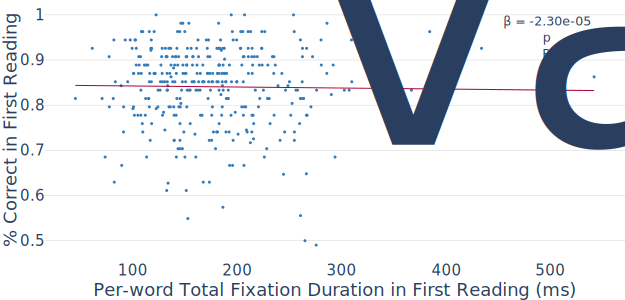

In [13]:
# Fit the regression model
X = personal_RR_raw_RT_diff["PERSONAL_FR_IA_DWELL_TIME"]
y = personal_RR_raw_RT_diff["comp_score_by_RR"]
X = sm.add_constant(X)  # Add a constant term to the predictor variable
model = sm.OLS(y, X).fit()

# Predict the values using the fitted model
y_pred = model.predict(X)

# Create the scatter plot with regression line
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=personal_RR_raw_RT_diff["PERSONAL_FR_IA_DWELL_TIME"],
        y=personal_RR_raw_RT_diff["comp_score_by_RR"],
        mode="markers",
        name="No preview",
        marker=dict(color=colors[0]),
        showlegend=False,
    )
)
# Add the slope and the p value to the graph
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.95,
    xanchor="right",
    yanchor="top",
    y=0.95,
    text=f"β = {model.params[1]:.2e}<br>p<sub>val</sub> = {model.pvalues[1]:.2e}<br>R<sup>2</sup> = {model.rsquared:.2e}",
    showarrow=False,
    font=dict(size=25),
)

# remove the grid background and make the grid lines black
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor="black")
fig.update_yaxes(showgrid=False, gridwidth=1, gridcolor="black")

# remove background
fig.update_layout(
    plot_bgcolor="white",
)

fig.add_trace(
    go.Scatter(
        x=personal_RR_raw_RT_diff["PERSONAL_FR_IA_DWELL_TIME"],
        y=y_pred,
        mode="lines",
        name="Regression line",
        line=dict(color=colors[1]),
        showlegend=False,
    )
)

# xlabel = "Per-word Total Fixation Duration in First Reading (ms)"
# ylabel = "Comprehension Score in First Reading"
height = 600
width = 1250
fig.update_layout(
    xaxis_title="Per-word Total Fixation Duration in First Reading (ms)",
    yaxis_title="% Correct in First Reading",
    font=dict(size=30),
    legend=dict(font=dict(size=30)),
    margin={"l": 0, "r": 0, "t": 0},
    height=height,
    width=width,
)

# turn the grid background to white
fig["layout"]["yaxis"]["showgrid"] = True
fig["layout"]["yaxis"]["gridcolor"] = "lightgray"

# increase the scale of fig by 2


fig.show(renderer="svg", scale=0.5)

In [13]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "sm_figures/personal_speed_compre.pdf",
)

### Per-Participant Response to word properties ~ Comprehension score


In [14]:
coef_names = ["(Intercept)", "Wordfreq_Frequency", "Length", "gpt2_Surprisal"]

In [15]:
response_outcome = "IA_DWELL_TIME"

ling_featurse_formula = f"""
{response_outcome} ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | subject_id) + 
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length | unique_paragraph_id)
"""

mm_coeftable0, ref_dfs0 = run_linear_mm(
    df_input=et_data_enriched.query("reread == 0 and first_read_out_of_2 == True"),
    outcome_variable=response_outcome,
    formula=ling_featurse_formula,
    re_cols=re_columns,
    print_model_res=False,
)

personal_ref_df0 = ref_dfs0[0]

# now, in merged_scores0, add to the (Intercept) column the fixed effect of the (intercept)
for coef in coef_names:
    fixed_effect = mm_coeftable0.loc[lambda x: x["Name"] == coef]["Coef."].values[0]
    personal_ref_df0[coef] += fixed_effect


mm_coeftable1, ref_dfs1 = run_linear_mm(
    df_input=et_data_enriched.query("reread == 1 and article_ind > 10"),
    outcome_variable=response_outcome,
    formula=ling_featurse_formula,
    re_cols=re_columns,
    print_model_res=False,
)

personal_ref_df1 = ref_dfs1[0]

for coef in coef_names:
    fixed_effect = mm_coeftable1.loc[lambda x: x["Name"] == coef]["Coef."].values[0]
    personal_ref_df1[coef] += fixed_effect

In [16]:
mm_coeftable_FR_all, response_df_all_FR = run_linear_mm(
    df_input=et_data_enriched.query(f"reread == 0 and {response_outcome} > 0"),
    outcome_variable=response_outcome,
    formula=ling_featurse_formula,
    re_cols=re_columns,
    print_model_res=False,
)

In [17]:
personal_response_df_all_FR = response_df_all_FR[0].copy()

for coef in coef_names:
    fixed_effect = mm_coeftable_FR_all.loc[lambda x: x["Name"] == coef]["Coef."].values[
        0
    ]
    personal_response_df_all_FR[coef] += fixed_effect

response_comp_df = pd.merge(
    personal_response_df_all_FR,
    paired_comp_scores,
    on="subject_id",
)

In [28]:
from copy import deepcopy
from pygam.utils import make_2d
from pygam.utils import load_diagonal
from types import MethodType


EPS = np.finfo(np.float64).eps  # machine epsilon


class FixedGAM(GAM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Reset the _initial_estimate method so it points to our override
        self.__dict__["_initial_estimate"] = FixedGAM._initial_estimate.__get__(
            self, self.__class__
        )

    def _initial_estimate(self, y, modelmat):
        """
        Makes an inital estimate for the model coefficients.

        For a LinearGAM we simply initialize to small coefficients.

        For other GAMs we transform the problem to the linear space
        and solve an unpenalized version.

        Parameters
        ---------
        y : array-like of shape (n,)
            containing target data
        modelmat : sparse matrix of shape (n, m)
            containing model matrix of the spline basis

        Returns
        -------
        coef : array of shape (m,) containing the initial estimate for the model
            coefficients

        Notes
        -----
            This method implements the suggestions in
            Wood, section 2.2.2 Geometry and IRLS convergence, pg 80
        """

        # do a simple initialization for LinearGAMs
        if isinstance(self, LinearGAM):
            n, m = modelmat.shape
            return np.ones(m) * np.sqrt(EPS)

        # transform the problem to the linear scale
        y = deepcopy(y).astype("float64")
        y[y == 0] += 0.01  # edge case for log link, inverse link, and logit link
        y[y == 1] -= 0.01  # edge case for logit link

        y_ = self.link.link(y, self.distribution)
        y_ = make_2d(y_, verbose=False)
        assert np.isfinite(y_).all(), (
            "transformed response values should be well-behaved."
        )

        # solve the linear problem
        return np.linalg.solve(
            load_diagonal(modelmat.T.dot(modelmat).toarray()), modelmat.T.dot(y_)
        )


In [30]:
fig = make_subplots(
    rows=1,
    cols=len(coef_names) - 1,
    subplot_titles=coef_names[1:],
    shared_yaxes=False,
    x_title="Comprehension Score in First Reading (% Correct)",
    y_title="Coefficient",
)
fig.update_annotations(font=dict(size=25))


for i, coef in enumerate(coef_names[1:]):
    # Add division by color and different line for each value in the column "has_preview"
    p_vals = []
    for has_preview_value, color in zip(
        has_preview_subs["has_preview"].unique(), colors[1:]
    ):
        print(i, coef, has_preview_value, color)
        has_preview_df = response_comp_df[
            response_comp_df["has_preview"] == has_preview_value
        ].sort_values("FR_comp_score")
        fig.add_trace(
            go.Scatter(
                x=has_preview_df["FR_comp_score"],
                y=has_preview_df[coef],
                mode="markers",
                name=has_preview_value,
                marker=dict(color=color),
                showlegend=True if i == 0 else False,
            ),
            row=1,
            col=i + 1,
        )

        X = has_preview_df["FR_comp_score"].to_numpy()
        X = X[:, np.newaxis]
        y = has_preview_df[coef]

        fixedgam = FixedGAM(n_splines=25, spline_order=6)

        fixedgam._initial_estimate = MethodType(FixedGAM._initial_estimate, fixedgam)

        gam = fixedgam.gridsearch(X, y)

        XX = gam.generate_X_grid(term=0, n=500)

        CIs = gam.confidence_intervals(XX, width=0.95)

        fig.add_trace(
            go.Scatter(
                x=XX.flatten(),
                y=CIs[:, 0],
                name="Lower Interval",
                line=dict(color=color, dash="dash"),
                showlegend=False,
                fill="tonexty",
            ),
            row=1,
            col=i + 1,
        )

        fig.add_trace(
            go.Scatter(
                x=XX.flatten(),
                y=CIs[:, 1],
                name="Upper Interval",
                line=dict(color=color, dash="dash"),
                showlegend=False,
                fill="tonexty",
            ),
            row=1,
            col=i + 1,
        )

        # Add the prediction line
        fig.add_trace(
            go.Scatter(
                x=XX.flatten(),
                y=gam.predict(XX),
                name="Prediction",
                line=dict(color=color),
                showlegend=False,
            ),
            row=1,
            col=i + 1,
        )

        p_vals.append(gam.statistics_["p_values"][0])

    # Add the slope and the p value to the graph
    fig.add_annotation(
        # xref="paper",
        yref="y domain",
        x=0.95,
        yanchor="top",
        xanchor="right",
        y=0.95,
        text=f"p<sub>val</sub> Gathering = {p_vals[0]:.2e}<br>p<sub>val</sub> Hunting = {p_vals[1]:.2e}<br>",
        showarrow=False,
        font=dict(size=15),
        row=1,
        col=i + 1,
    )

# Update the layout and show the figure
height = 600
width = 2000
fig.update_layout(
    font=dict(size=20),
    height=height,
    width=width,
    title_text=f"{outcome_name_mapping[response_outcome]} > 0",
)

fig.show(renderer="png")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


0 Wordfreq_Frequency Gathering #AE0135


AttributeError: 'csr_matrix' object has no attribute 'A'

## Individual Differences Results Reported in the Paper

In [31]:
if comparison_mode == "diff":
    personal_coefs_diffs_df = personal_ref_df1.copy()
    personal_coefs_diffs_df["Wordfreq_Frequency"] = (
        personal_ref_df1["Wordfreq_Frequency"] - personal_ref_df0["Wordfreq_Frequency"]
    )
    personal_coefs_diffs_df["gpt2_Surprisal"] = (
        personal_ref_df1["gpt2_Surprisal"] - personal_ref_df0["gpt2_Surprisal"]
    )
    personal_coefs_diffs_df["Length"] = (
        personal_ref_df1["Length"] - personal_ref_df0["Length"]
    )
if comparison_mode == "ratio":
    personal_coefs_diffs_df = personal_ref_df1.copy()
    personal_coefs_diffs_df["Wordfreq_Frequency"] = (
        personal_ref_df1["Wordfreq_Frequency"] / personal_ref_df0["Wordfreq_Frequency"]
    )
    personal_coefs_diffs_df["gpt2_Surprisal"] = (
        personal_ref_df1["gpt2_Surprisal"] / personal_ref_df0["gpt2_Surprisal"]
    )
    personal_coefs_diffs_df["Length"] = (
        personal_ref_df1["Length"] / personal_ref_df0["Length"]
    )

# remove the (Intercept) column
personal_coefs_diffs_df = personal_coefs_diffs_df.drop(columns=["(Intercept)"])

# to all columns that are nit subject_id, add _RR_diff
personal_coefs_diffs_df = personal_coefs_diffs_df.rename(
    columns={
        x: f"Coef_{x}_RR_diff"
        for x in personal_coefs_diffs_df.columns
        if x != "subject_id"
    }
)
personal_coefs_diffs_df = pd.merge(
    personal_coefs_diffs_df,
    FR_RR_compre_scores.query("reread == 0").drop(columns=["reread"]),
    on="subject_id",
)

has_preview_subs = et_data_enriched[
    ["has_preview", "subject_id", "sub_FR_mean_RT"]
].drop_duplicates()
personal_coefs_diffs_df = pd.merge(
    personal_coefs_diffs_df, has_preview_subs, on="subject_id"
)
personal_coefs_diffs_df = personal_coefs_diffs_df.loc[
    :, ~personal_coefs_diffs_df.columns.duplicated()
].copy()
personal_coefs_diffs_df = personal_coefs_diffs_df.rename(
    columns={"sub_FR_mean_RT": "PERSONAL_FR_IA_DWELL_TIME"}
)
personal_coefs_diffs_df

,subject_id,Coef_Wordfreq_Frequency_RR_diff,Coef_gpt2_Surprisal_RR_diff,Coef_Length_RR_diff,comp_score_by_RR,has_preview,PERSONAL_FR_IA_DWELL_TIME
0,L41_408,-3.348743,-2.027704,-0.230650,0.792453,Gathering,100.169889
1,L56_481,0.966508,-5.873226,-22.360345,0.796296,Gathering,270.692477
2,l10_202,-13.063878,-7.089323,-4.092654,0.851852,Gathering,262.331212
3,l10_269,-2.414212,0.697778,-14.108739,0.907407,Gathering,157.794514
4,l10_338,-2.745631,-5.397404,-12.424603,0.759259,Hunting,154.995725
...,...,...,...,...,...,...,...
355,l9_201,-10.771014,-4.483842,11.461000,0.888889,Gathering,204.467687
356,l9_340,-5.731780,-0.986179,-5.640704,0.722222,Gathering,139.664000
357,l9_38,-2.453784,0.657164,-5.727753,0.907407,Hunting,107.402688
358,l9_491,-1.243822,-0.006246,-6.731332,0.792453,Gathering,122.429132


PERSONAL_RR_IA_FIRST_FIXATION_DURATION_DIFF
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 5.57e-13
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 2.54e-01
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 1.95e-05
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 9.76e-02
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 1.63e-03

PERSONAL_RR_IA_FIRST_RUN_DWELL_TIME_DIFF
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 4.62e-17
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 3.28e-01
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 5.06e-08
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 1.54e-01
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 9.40e-04

PERSONAL_RR_IA_FIRST_PASS_GAZE_DURATION_DIFF
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 3.00e-08

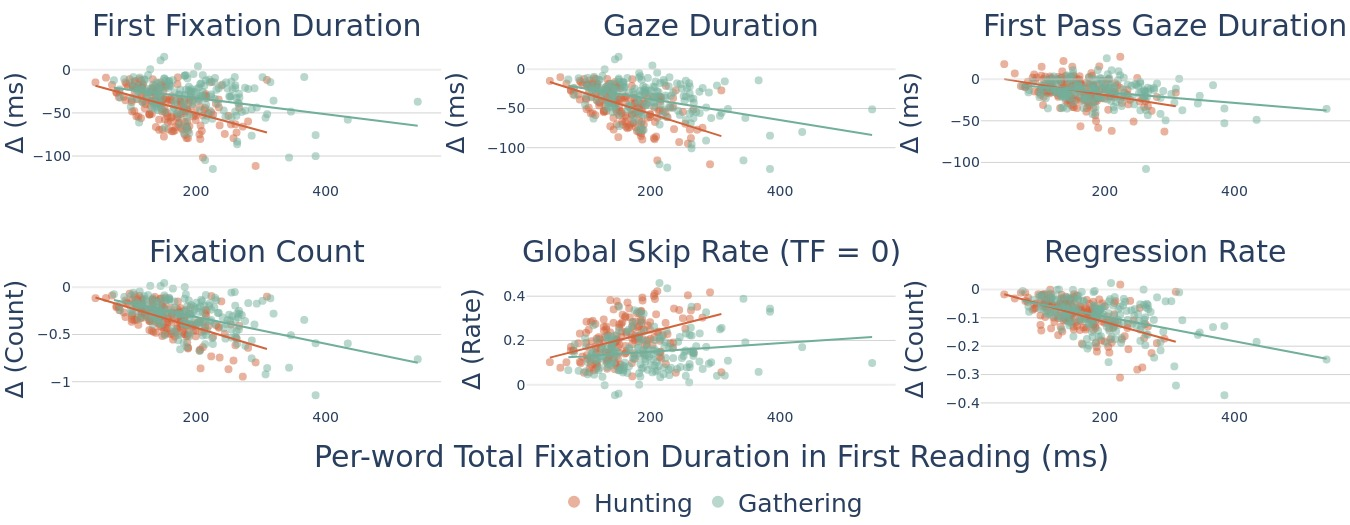

PERSONAL_RR_IA_FIRST_FIXATION_DURATION_DIFF
Comprehension Score in First Reading (% Correct) p_val_hunting: 8.42e-01
Comprehension Score in First Reading (% Correct) R_hunting: 2.23e-04
Comprehension Score in First Reading (% Correct) p_val_gathering: 5.43e-01
Comprehension Score in First Reading (% Correct) R_gathering: 2.08e-03
Comprehension Score in First Reading (% Correct) interaction_p_val: 5.90e-01

PERSONAL_RR_IA_FIRST_RUN_DWELL_TIME_DIFF
Comprehension Score in First Reading (% Correct) p_val_hunting: 9.35e-01
Comprehension Score in First Reading (% Correct) R_hunting: 3.77e-05
Comprehension Score in First Reading (% Correct) p_val_gathering: 4.49e-01
Comprehension Score in First Reading (% Correct) R_gathering: 3.22e-03
Comprehension Score in First Reading (% Correct) interaction_p_val: 5.84e-01

PERSONAL_RR_IA_FIRST_PASS_GAZE_DURATION_DIFF
Comprehension Score in First Reading (% Correct) p_val_hunting: 5.03e-01
Comprehension Score in First Reading (% Correct) R_hunting: 2.53e

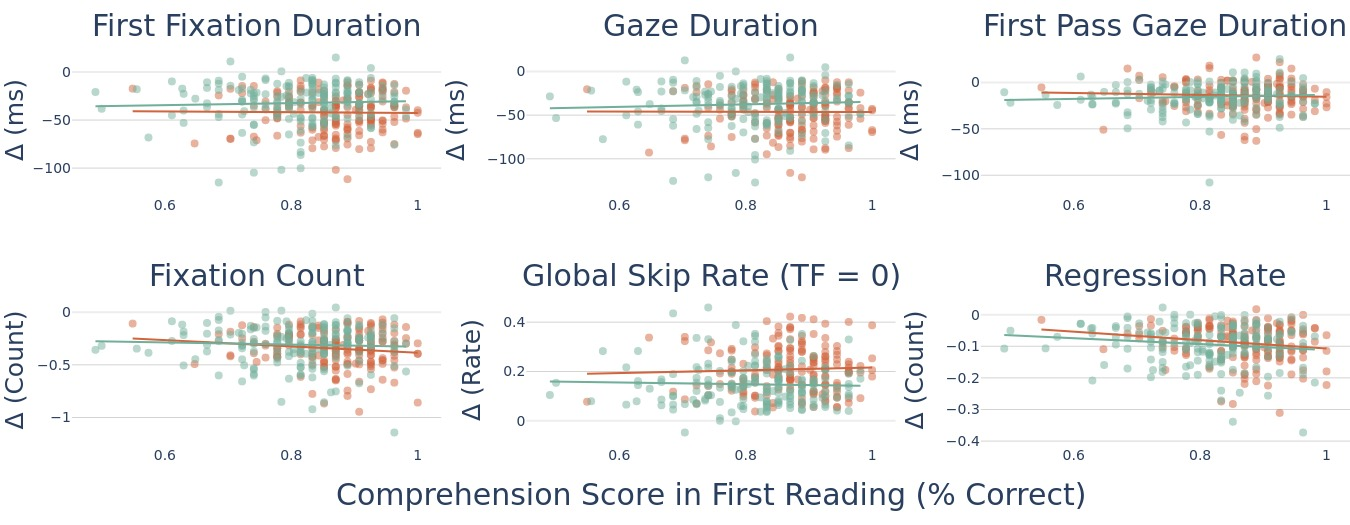

Coef_Wordfreq_Frequency_RR_diff
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 1.86e-04
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 7.57e-02
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 3.01e-02
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 2.61e-02
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 8.43e-02

Coef_gpt2_Surprisal_RR_diff
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 1.08e-10
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 2.09e-01
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 6.08e-10
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 1.94e-01
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 1.67e-01

Coef_Length_RR_diff
Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 9.84e-08
Per-word Total Fixation Duration in First Reading

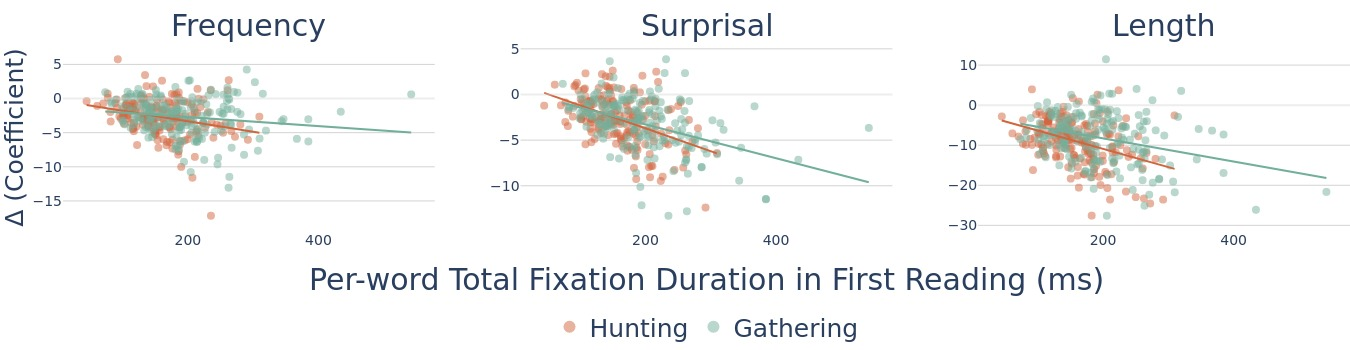

Coef_Wordfreq_Frequency_RR_diff
Comprehension Score in First Reading (% Correct) p_val_hunting: 3.85e-01
Comprehension Score in First Reading (% Correct) R_hunting: 4.24e-03
Comprehension Score in First Reading (% Correct) p_val_gathering: 5.63e-01
Comprehension Score in First Reading (% Correct) R_gathering: 1.88e-03
Comprehension Score in First Reading (% Correct) interaction_p_val: 3.02e-01

Coef_gpt2_Surprisal_RR_diff
Comprehension Score in First Reading (% Correct) p_val_hunting: 7.40e-01
Comprehension Score in First Reading (% Correct) R_hunting: 6.23e-04
Comprehension Score in First Reading (% Correct) p_val_gathering: 4.55e-01
Comprehension Score in First Reading (% Correct) R_gathering: 3.14e-03
Comprehension Score in First Reading (% Correct) interaction_p_val: 8.14e-01

Coef_Length_RR_diff
Comprehension Score in First Reading (% Correct) p_val_hunting: 6.38e-02
Comprehension Score in First Reading (% Correct) R_hunting: 1.92e-02
Comprehension Score in First Reading (% Correc

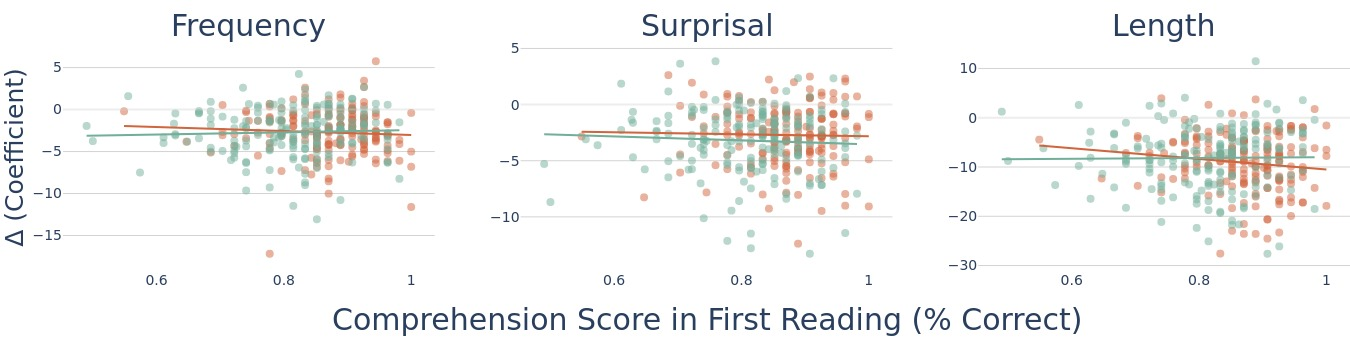

comp_score_diff
Comprehension Score in First Reading (% Correct) p_val_hunting: 3.58e-07
Comprehension Score in First Reading (% Correct) R_hunting: 1.36e-01
Comprehension Score in First Reading (% Correct) p_val_gathering: 2.85e-03
Comprehension Score in First Reading (% Correct) R_gathering: 4.89e-02
Comprehension Score in First Reading (% Correct) interaction_p_val: 7.59e-02



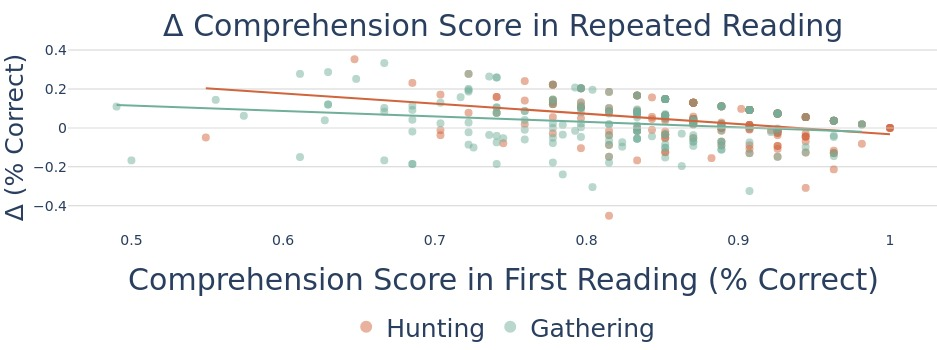

In [32]:
diff_sign = "Δ" if comparison_mode == "diff" else "Ratio"

outcome_name_mapping["Wordfreq_Frequency"] = "Frequency"
outcome_name_mapping["gpt2_Surprisal"] = "Surprisal"
outcome_name_mapping["Length"] = "Length"
outcome_name_mapping["comp_score_diff"] = (
    f"{diff_sign} Comprehension Score in Repeated Reading"
)

color1 = "#D1653E"
color2 = "#72AF9B"


def plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    x_var,
    x_var_name,
    outcomes=all_outcomes,
    include_legend=True,
):
    # Create subplots with 2 rows and 3 columns
    if len(outcomes) > 3:
        fig = make_subplots(
            rows=2,
            cols=3,
            subplot_titles=[outcome_name_mapping[outcome] for outcome in outcomes],
            x_title=x_var_name,
        )
    else:
        fig = make_subplots(
            rows=1,
            cols=len(outcomes),
            subplot_titles=[outcome_name_mapping[outcome] for outcome in outcomes],
            x_title=x_var_name,
        )

    for i in fig["layout"]["annotations"]:
        i["font"] = dict(size=40)
    # Iterate over each outcome in all_outcomes
    for i, outcome in enumerate(outcomes):
        # Add a scatter plot for 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR for "Hunting"
        if outcome in all_outcomes:
            y_name = f"PERSONAL_RR_{outcome}_DIFF"
        elif outcome == "comp_score_diff":
            y_name = "comp_score_diff"
        elif outcome in ["Wordfreq_Frequency", "gpt2_Surprisal", "Length"]:
            y_name = f"Coef_{outcome}_RR_diff"

        fig.add_trace(
            go.Scatter(
                x=personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == "Hunting"
                ][x_var],
                y=personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == "Hunting"
                ][y_name],
                mode="markers",
                name="Hunting",
                marker={"color": color1},  # Change color to #01895D
                showlegend=(i == 0),  # Only show legend for the first plot
            ),
            row=(i // 3) + 1,
            col=(i % 3) + 1,
        )
        fig.add_hline(
            y=0, line_color="lightgray", row=(i // 3) + 1, col=(i % 3) + 1, opacity=0.4
        )

        # Add a scatter plot for 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR for "Gathering"
        fig.add_trace(
            go.Scatter(
                x=personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == "Gathering"
                ][x_var],
                y=personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == "Gathering"
                ][y_name],
                mode="markers",
                name="Gathering",
                marker={"color": color2},  # Change color to #718901
                showlegend=(i == 0),
            ),
            row=(i // 3) + 1,
            col=(i % 3) + 1,
        )
        # use statsmodels to fit a linear regression
        # and plot the line of best fit for "Hunting"
        x_hunting = personal_RR_raw_RT_diff[
            personal_RR_raw_RT_diff["has_preview"] == "Hunting"
        ][x_var]
        y_hunting = personal_RR_raw_RT_diff[
            personal_RR_raw_RT_diff["has_preview"] == "Hunting"
        ][y_name]
        model_hunting = OLS(y_hunting, add_constant(x_hunting)).fit()
        fig.add_trace(
            go.Scatter(
                x=x_hunting,
                y=model_hunting.predict(),
                mode="lines",
                name="Hunting",
                line={"color": color1},  # Change color to red
                showlegend=False,
            ),
            row=(i // 3) + 1,
            col=(i % 3) + 1,
        )
        slope_p_val_hunting = model_hunting.pvalues[1]

        # use statsmodels to fit a linear regression
        # and plot the line of best fit for "Gathering"
        x_gathering = personal_RR_raw_RT_diff[
            personal_RR_raw_RT_diff["has_preview"] == "Gathering"
        ][x_var]
        y_gathering = personal_RR_raw_RT_diff[
            personal_RR_raw_RT_diff["has_preview"] == "Gathering"
        ][y_name]
        model_gathering = OLS(y_gathering, add_constant(x_gathering)).fit()
        fig.add_trace(
            go.Scatter(
                x=x_gathering,
                y=model_gathering.predict(),
                mode="lines",
                name="Gathering",
                showlegend=False,
                line={"color": color2},  # Change color to orange
            ),
            row=(i // 3) + 1,
            col=(i % 3) + 1,
        )
        fig.update_traces(marker=dict(opacity=0.5))
        slope_p_val_gathering = model_gathering.pvalues[1]

        # add a model for the interaction between x_var and has_preview Formula: 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR * has_preview
        interaction_model = smf.ols(
            formula=f"{y_name} ~ {x_var} * has_preview", data=personal_RR_raw_RT_diff
        ).fit()
        # get p val of the interaction
        interaction_p_val = interaction_model.pvalues[3]

        # add the p values as annotations in the top right corner
        # print the x_var_name and the p values
        print(y_name)
        print(f"{x_var_name} p_val_hunting: {slope_p_val_hunting:.2e}")
        print(f"{x_var_name} R_hunting: {model_hunting.rsquared:.2e}")
        print(f"{x_var_name} p_val_gathering: {slope_p_val_gathering:.2e}")
        print(f"{x_var_name} R_gathering: {model_gathering.rsquared:.2e}")
        print(f"{x_var_name} interaction_p_val: {interaction_p_val:.2e}")
        print()

        # update yaxis
        if comparison_mode == "diff":
            if outcome in all_outcomes and outcome not in [
                "IA_SKIP",
                "IA_RUN_COUNT",
                "IA_REGRESSION_OUT_FULL_COUNT",
                "IA_ZERO_TF",
            ]:
                units = "Δ (ms)"
            elif outcome in ["IA_SKIP", "IA_ZERO_TF"]:
                units = "Δ (Rate)"
            elif outcome in ["IA_RUN_COUNT", "IA_REGRESSION_OUT_FULL_COUNT"]:
                units = "Δ (Count)"
            elif outcome in ["Wordfreq_Frequency"]:
                units = "Δ (Coefficient)"
            elif outcome == "comp_score_diff":
                units = "Δ (% Correct)"
            else:
                units = ""
        elif comparison_mode == "ratio":
            units = "Ratio"

        fig.update_yaxes(
            title_text=units,
            row=(i // 3) + 1,
            col=(i % 3) + 1,
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )

        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

        fig.update_yaxes(
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )
        fig.update_xaxes(
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )

    # change the location of the legend
    if include_legend:
        fig.update_layout(
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.2 if len(outcomes) > 3 else -0.4,
                xanchor="center",
                x=0.5,
                font=dict(size=25),  # Increase font size by 20
                itemsizing="constant",
            )
        )

        # dont show legend
    else:
        fig.update_layout(showlegend=False)
    # change the marker size of the legend (AND ONLY THE LEGEND)
    fig.update_traces(marker=dict(size=8))
    # change the marker size of the legend (AND ONLY THE LEGEND)
    for i in fig["layout"]["annotations"]:
        if i["text"] == x_var_name:
            i["font"] = dict(size=35)
    for i in range(len(outcomes)):
        # turn the grid background to white
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"
    fig.update_layout(
        height=350 * 1.5 if len(outcomes) > 3 else 350,
        width=1350 if len(outcomes) > 1 else 937.5,
    )

    # increse all font by 10
    fig.update_layout(font=dict(size=30))
    fig.update_annotations(font_size=30)
    # # Show the plot
    fig.update_layout(margin={"l": 0, "r": 0, "t": 45})
    fig.show(renderer="jpg")
    return fig


# grt_outcomes = ["IA_DWELL_TIME", "IA_SKIP"]
grt_outcomes = all_outcomes
personal_RT = plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    "PERSONAL_FR_IA_DWELL_TIME",
    "Per-word Total Fixation Duration in First Reading (ms)",
    outcomes=grt_outcomes,
    include_legend=True,
)
personal_comp = plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    "comp_score_by_RR",
    "Comprehension Score in First Reading (% Correct)",
    grt_outcomes,
    include_legend=False,
)
personal_RT_coefs = plot_raw_RR_FR_diff_all_outcomes(
    personal_coefs_diffs_df,
    "PERSONAL_FR_IA_DWELL_TIME",
    "Per-word Total Fixation Duration in First Reading (ms)",
    outcomes=["Wordfreq_Frequency", "gpt2_Surprisal", "Length"],
    include_legend=True,
)
personal_comp_coefs = plot_raw_RR_FR_diff_all_outcomes(
    personal_coefs_diffs_df,
    "comp_score_by_RR",
    "Comprehension Score in First Reading (% Correct)",
    outcomes=["Wordfreq_Frequency", "gpt2_Surprisal", "Length"],
    include_legend=False,
)
comp_diff_personal_comp = plot_raw_RR_FR_diff_all_outcomes(
    paired_comp_scores,
    "FR_comp_score",
    "Comprehension Score in First Reading (% Correct)",
    outcomes=["comp_score_diff"],
)

In [33]:
upload(
    personal_RT,
    "CogSci 2024 - Rereading",
    "sm_figures/personal_RT.pdf",
)
upload(
    personal_comp,
    "CogSci 2024 - Rereading",
    "sm_figures/personal_comp.pdf",
)

upload(
    personal_RT_coefs,
    "CogSci 2024 - Rereading",
    "sm_figures/personal_RT_coefs.pdf",
)
upload(
    personal_comp_coefs,
    "CogSci 2024 - Rereading",
    "sm_figures/personal_comp_coefs.pdf",
)

upload(
    comp_diff_personal_comp,
    "CogSci 2024 - Rereading",
    "sm_figures/comp_diff_personal_comp.pdf",
)

Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 2.03e-30
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 5.23e-01
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 2.68e-25
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 4.56e-01
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 3.46e-02

Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 2.30e-01
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 8.10e-03
Per-word Total Fixation Duration in First Reading (ms) p_val_gathering: 6.11e-01
Per-word Total Fixation Duration in First Reading (ms) R_gathering: 1.46e-03
Per-word Total Fixation Duration in First Reading (ms) interaction_p_val: 6.12e-01

Per-word Total Fixation Duration in First Reading (ms) p_val_hunting: 5.17e-04
Per-word Total Fixation Duration in First Reading (ms) R_hunting: 6.57e-02
Per-word Total Fixation Duration in First Reading (ms)

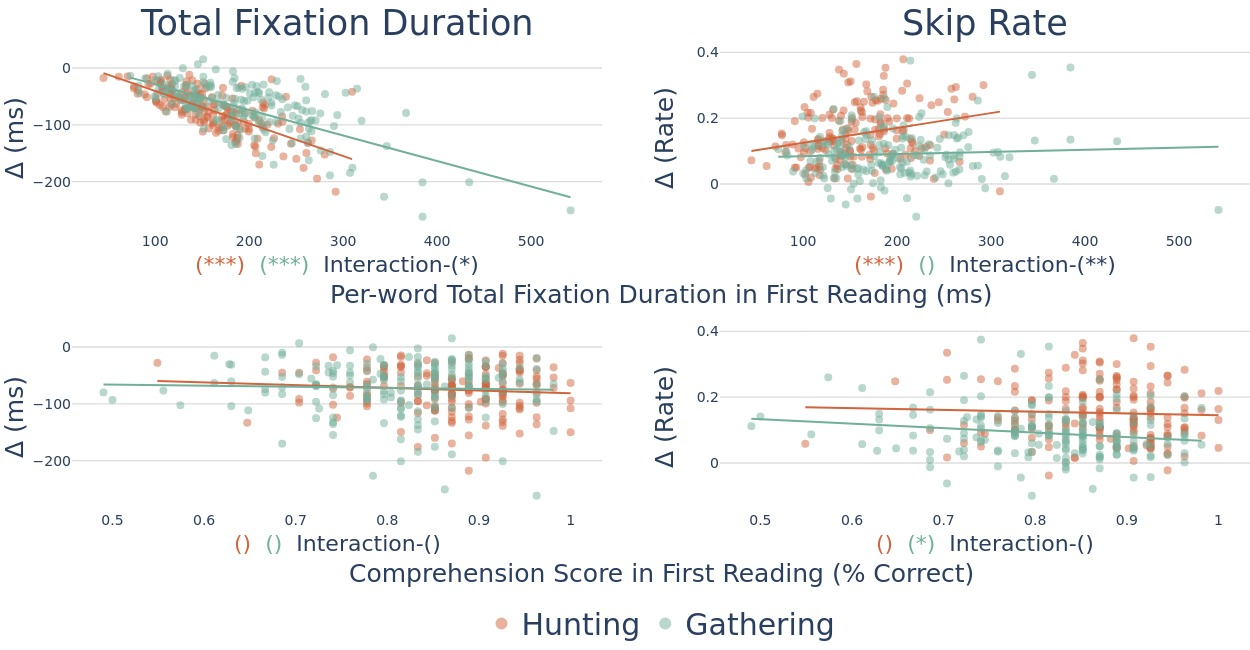

In [34]:
diff_sign = "Δ" if comparison_mode == "diff" else "Ratio"

outcome_name_mapping["Wordfreq_Frequency"] = "Frequency"
outcome_name_mapping["gpt2_Surprisal"] = "Surprisal"
outcome_name_mapping["Length"] = "Length"
outcome_name_mapping["comp_score_diff"] = (
    f"{diff_sign} Comprehension Score In Repeated Reading"
)


def plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    x_var,
    x_var_name,
    outcomes=all_outcomes,
    include_legend=True,
):
    fig = make_subplots(
        rows=2,
        cols=2,
        shared_xaxes="rows",
        shared_yaxes="columns",
        vertical_spacing=0.2,
        horizontal_spacing=0.1,
        column_titles=["Total Fixation Duration", "Skip Rate"],
    )

    for i in fig["layout"]["annotations"]:
        i["font"] = dict(size=35)
    # Iterate over each outcome in all_outcomes
    for j, outcome in enumerate(outcomes):
        for i, x_var in enumerate(["PERSONAL_FR_IA_DWELL_TIME", "comp_score_by_RR"]):
            # Add a scatter plot for 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR for "Hunting"
            if outcome in all_outcomes + ["IA_SKIP", "IA_DWELL_TIME"]:
                y_name = f"PERSONAL_RR_{outcome}_DIFF"
            elif outcome == "comp_score_diff":
                y_name = "comp_score_diff"
            elif outcome in ["Wordfreq_Frequency", "gpt2_Surprisal", "Length"]:
                y_name = f"Coef_{outcome}_RR_diff"

            fig.add_trace(
                go.Scatter(
                    x=personal_RR_raw_RT_diff[
                        personal_RR_raw_RT_diff["has_preview"] == "Hunting"
                    ][x_var],
                    y=personal_RR_raw_RT_diff[
                        personal_RR_raw_RT_diff["has_preview"] == "Hunting"
                    ][y_name],
                    mode="markers",
                    name="Hunting",
                    marker={"color": color1},  # Change color to #01895D
                    showlegend=(
                        i == 0 and j == 0
                    ),  # Only show legend for the first plot
                ),
                row=i + 1,
                col=j + 1,
            )
            fig.add_hline(y=0, line_color="gray", row=i + 1, col=j + 1, opacity=0.2)

            # Add a scatter plot for 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR for "Gathering"
            fig.add_trace(
                go.Scatter(
                    x=personal_RR_raw_RT_diff[
                        personal_RR_raw_RT_diff["has_preview"] == "Gathering"
                    ][x_var],
                    y=personal_RR_raw_RT_diff[
                        personal_RR_raw_RT_diff["has_preview"] == "Gathering"
                    ][y_name],
                    mode="markers",
                    name="Gathering",
                    marker={"color": color2},  # Change color to #718901
                    showlegend=(i == 0 and j == 0),
                ),
                row=i + 1,
                col=j + 1,
            )
            # use statsmodels to fit a linear regression
            # and plot the line of best fit for "Hunting"
            x_hunting = personal_RR_raw_RT_diff[
                personal_RR_raw_RT_diff["has_preview"] == "Hunting"
            ][x_var]
            y_hunting = personal_RR_raw_RT_diff[
                personal_RR_raw_RT_diff["has_preview"] == "Hunting"
            ][y_name]
            model_hunting = OLS(y_hunting, add_constant(x_hunting)).fit()
            fig.add_trace(
                go.Scatter(
                    x=x_hunting,
                    y=model_hunting.predict(),
                    mode="lines",
                    name="Hunting",
                    line={"color": color1},  # Change color to red
                    showlegend=False,
                ),
                row=i + 1,
                col=j + 1,
            )
            slope_p_val_hunting = model_hunting.pvalues[1]

            # use statsmodels to fit a linear regression
            # and plot the line of best fit for "Gathering"
            x_gathering = personal_RR_raw_RT_diff[
                personal_RR_raw_RT_diff["has_preview"] == "Gathering"
            ][x_var]
            y_gathering = personal_RR_raw_RT_diff[
                personal_RR_raw_RT_diff["has_preview"] == "Gathering"
            ][y_name]
            model_gathering = OLS(y_gathering, add_constant(x_gathering)).fit()
            fig.add_trace(
                go.Scatter(
                    x=x_gathering,
                    y=model_gathering.predict(),
                    mode="lines",
                    name="Gathering",
                    showlegend=False,
                    line={"color": color2},  # Change color to orange
                ),
                row=i + 1,
                col=j + 1,
            )
            fig.update_traces(marker=dict(opacity=0.5))
            slope_p_val_gathering = model_gathering.pvalues[1]

            # add a model for the interaction between x_var and has_preview Formula: 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR * has_preview
            interaction_model = smf.ols(
                formula=f"{y_name} ~ {x_var} * has_preview",
                data=personal_RR_raw_RT_diff,
            ).fit()
            # get p val of the interaction
            interaction_p_val = interaction_model.pvalues[3]

            # update xaxis
            # fig.update_xaxes(title_text=f"{x_var_name}", row=(i // 3) + 1, col=(i % 3) + 1)

            # add the p values as annotations in the top right corner
            # print the x_var_name and the p values
            print(f"{x_var_name} p_val_hunting: {slope_p_val_hunting:.2e}")
            print(f"{x_var_name} R_hunting: {model_hunting.rsquared:.2e}")
            print(f"{x_var_name} p_val_gathering: {slope_p_val_gathering:.2e}")
            print(f"{x_var_name} R_gathering: {model_gathering.rsquared:.2e}")
            print(f"{x_var_name} interaction_p_val: {interaction_p_val:.2e}")
            print()

            # update yaxis
            if comparison_mode == "diff":
                if outcome in all_outcomes + ["IA_DWELL_TIME"] and outcome not in [
                    "IA_SKIP",
                    "IA_RUN_COUNT",
                    "IA_REGRESSION_OUT_FULL_COUNT",
                ]:
                    units = "Δ (ms)"
                elif outcome == "IA_SKIP":
                    units = "Δ (Rate)"
                elif outcome == "IA_RUN_COUNT":
                    units = "Δ (Count)"
                elif outcome in ["Wordfreq_Frequency"]:
                    units = "Δ (Coefficient)"
                elif outcome == "comp_score_diff":
                    units = "Δ (% Correct)"
                else:
                    units = ""
            elif comparison_mode == "ratio":
                units = "Ratio"

            fig.update_yaxes(
                title_text=units,
                row=i + 1,
                col=j + 1,
                title_font=dict(size=25),
                tickfont=dict(size=14),
            )

            fig.update_layout(
                plot_bgcolor="rgba(0,0,0,0)",
                # xaxis=dict(gridcolor="LightGray"),
                yaxis=dict(gridcolor="LightGray"),
            )

            fig.update_yaxes(
                title_font=dict(size=25),
                tickfont=dict(size=14),
            )
            fig.update_xaxes(
                title_font=dict(size=25),
                tickfont=dict(size=14),
            )
            H_p_val_marking = (
                "(***)"
                if slope_p_val_hunting < 0.001
                else (
                    "(**)"
                    if slope_p_val_hunting < 0.01
                    else "(*)"
                    if slope_p_val_hunting < 0.05
                    else "()"
                )
            )
            G_p_val_marking = (
                "(***)"
                if slope_p_val_gathering < 0.001
                else (
                    "(**)"
                    if slope_p_val_gathering < 0.01
                    else "(*)"
                    if slope_p_val_gathering < 0.05
                    else "()"
                )
            )
            interaction_p_val_marking = (
                "(***)"
                if interaction_p_val < 0.001
                else (
                    "(**)"
                    if interaction_p_val < 0.01
                    else "(*)"
                    if interaction_p_val < 0.05
                    else "()"
                )
            )

            # add annotations for the p values (use the appropriate colors of the lines)
            fig.add_annotation(
                xref="x domain",
                yref="y domain",
                x=0.5,
                y=-0.1,
                text="  ".join(
                    [
                        f'<span style="color:{color1};">{H_p_val_marking}</span>',
                        f'<span style="color:{color2};">{G_p_val_marking}</span>',
                        f"<span>Interaction-{interaction_p_val_marking}</span>",
                    ]
                ),
                showarrow=False,
                align="left",
                font=dict(size=22),
                xanchor="center",
                yanchor="top" if j == 0 else "top",
                row=i + 1,
                col=j + 1,
            )

    # change the location of the legend
    if include_legend:
        if len(outcomes) > 3:
            fig.update_layout(
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=0.35,
                    xanchor="left",
                    x=0.66,
                    # set font to 20
                    font=dict(size=25),  # Increase font size by 20
                )
            )
        else:
            fig.update_layout(
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=-0.3 if len(outcomes) > 1 else -0.7,
                    xanchor="center",
                    x=0.5,
                    font=dict(size=30),  # Increase font size by 20
                    itemsizing="constant",
                )
            )
            # fig.update_layout(legend=dict(
            #     yanchor="top",
            #     y=0.95,
            #     xanchor="right",
            #     x=1,
            #     font=dict(
            #         size=20  # Increase font size by 20
            #     ),
            #     bordercolor="Black",
            #     borderwidth=1,
            # ))
        # dont show legend
    else:
        fig.update_layout(showlegend=False)
    # change the marker size of the legend (AND ONLY THE LEGEND)
    fig.update_traces(marker=dict(size=8))
    # change the marker size of the legend (AND ONLY THE LEGEND)
    for i in fig["layout"]["annotations"]:
        if i["text"] == x_var_name:
            i["font"] = dict(size=35)
    for i in range(len(outcomes) + 2):
        # turn the grid background to white
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"
    fig.update_layout(
        height=700 * 1.5 if len(outcomes) > 3 else 650,
        width=1250 if len(outcomes) > 1 else 850,
    )
    # add the text "Per-word Total Fixation Duration In First Reading" in y=0.5 and x=0.5
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=0.5,
        y=0.5,
        text="Per-word Total Fixation Duration in First Reading (ms)",
        showarrow=False,
        font=dict(size=25),
        xanchor="center",
        yanchor="top",
    )
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=0.5,
        y=-0.1,
        text="Comprehension Score in First Reading (% Correct)",
        showarrow=False,
        font=dict(size=25),
        xanchor="center",
        yanchor="top",
    )

    # increse all font by 10
    fig.update_layout(font=dict(size=30))
    # fig.update_annotations(font_size=30)
    # # Show the plot
    fig.update_layout(margin={"l": 0, "r": 0, "t": 45})
    fig.show(renderer="jpg")
    return fig


grt_outcomes = ["IA_DWELL_TIME", "IA_SKIP"]
# grt_outcomes = all_outcomes
TF_SR_personal_combined = plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    "PERSONAL_FR_IA_DWELL_TIME",
    "Per-word Total Fixation Duration in First Reading (ms)",
    outcomes=grt_outcomes,
    include_legend=True,
)

In [35]:
upload(
    TF_SR_personal_combined,
    "CogSci 2024 - Rereading",
    f"{'sm_figures' if comparison_mode == 'ratio' else 'main_figures'}/TF_SR_personal_combined{'_ratio' if comparison_mode == 'ratio' else ''}.pdf",
)

## Separating consecutive, non-consecutive repeated reading


In [36]:
# Personal diff between read and reread:
personal_RR_raw_outcome_diff = None
for outcome in ["IA_DWELL_TIME"] + all_outcomes:
    trial_RT_FR = (
        et_data_enriched.query("article_ind <= 10 and first_read_out_of_2 == True")[
            [outcome, "subject_id", "has_preview", "article_ind"]
        ]
        .groupby(["subject_id", "has_preview", "article_ind"])
        .mean()
        .reset_index()
        .rename(columns={outcome: f"PERSONAL_FR_{outcome}"})
        .replace({"article_ind": {10: "consecutive"}})
        .replace({"article_ind": {i: "nonconsecutive" for i in range(1, 10)}})
    )

    trial_RT_RR = (
        et_data_enriched.query("article_ind > 10")[
            [outcome, "subject_id", "has_preview", "article_ind"]
        ]
        .groupby(["subject_id", "has_preview", "article_ind"])
        .mean()
        .reset_index()
        .rename(columns={outcome: f"PERSONAL_RR_{outcome}"})
        .replace({"article_ind": {11: "consecutive"}})
        .replace({"article_ind": {12: "nonconsecutive"}})
    )

    # for each row in trial_RT_RR substract the corresponding row in trial_RT_FR (with same subject_id, has_preview and article_ind)
    merged = trial_RT_RR.merge(
        trial_RT_FR, on=["subject_id", "has_preview", "article_ind"], how="inner"
    )

    if personal_RR_raw_outcome_diff is None:
        personal_RR_raw_outcome_diff = merged
        # drop PERSONAL_RR_IA_DWELL_TIME and PERSONAL_FR_IA_DWELL_TIME
        personal_RR_raw_outcome_diff = personal_RR_raw_outcome_diff.drop(
            columns=[f"PERSONAL_RR_{outcome}"]
        )
    if comparison_mode == "diff":
        personal_RR_raw_outcome_diff[f"PERSONAL_RR_{outcome}_DIFF"] = (
            merged[f"PERSONAL_RR_{outcome}"] - merged[f"PERSONAL_FR_{outcome}"]
        )
    elif comparison_mode == "ratio":
        personal_RR_raw_outcome_diff[f"PERSONAL_RR_{outcome}_DIFF"] = (
            merged[f"PERSONAL_RR_{outcome}"] / merged[f"PERSONAL_FR_{outcome}"]
        )


personal_RR_raw_RT_diff = pd.merge(
    personal_RR_raw_outcome_diff,
    FR_RR_compre_scores.query("reread == 0").drop(columns=["reread"]),
    on="subject_id",
)

# change column name of article_ind to consec_reread
personal_RR_raw_RT_diff = personal_RR_raw_RT_diff.rename(
    columns={"article_ind": "consec_reread"}
)

In [37]:
ling_featurse_formula = """
IA_DWELL_TIME ~ Wordfreq_Frequency:Length + Wordfreq_Frequency * reread + Length * reread + gpt2_Surprisal * reread + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length
"""

# create a dataframe to hold the coefficients
coeffs_to_save = ["Wordfreq_Frequency:reread", "Length:reread", "gpt2_Surprisal:reread"]
coefs_df = pd.DataFrame(
    columns=["subject_id", "has_preview", "consec_reread"] + coeffs_to_save
)


# for each subject_id
for subject_id in tqdm(et_data_enriched["subject_id"].unique()):
    for consec in ["consecutive", "nonconsecutive"]:
        if consec == "consecutive":
            sub_df = et_data_enriched.query(
                f"subject_id == '{subject_id}' and article_ind >= 10"
            )
        if consec == "nonconsecutive":
            sub_df = et_data_enriched.query(
                f"subject_id == '{subject_id}' and ((article_ind < 10 and first_read_out_of_2 == True) or article_ind == 12)"
            )
        # fit a model
        model = ols(ling_featurse_formula, data=sub_df).fit()
        # save the coefficients
        coefs_df = pd.concat(
            [
                coefs_df,
                pd.DataFrame(
                    [
                        [
                            subject_id,
                            et_data_enriched.query(f"subject_id == '{subject_id}'")[
                                "has_preview"
                            ].values[0],
                            consec,
                        ]
                        + list(
                            [
                                model.params[interaction_term]
                                for interaction_term in coeffs_to_save
                            ]
                        )
                    ],
                    columns=["subject_id", "has_preview", "consec_reread"]
                    + coeffs_to_save,
                ),
            ],
            axis=0,
        )

# insgtead of ling:reread set f"Coef_ling_RR_diff"
coefs_df = coefs_df.rename(
    columns={x: f"Coef_{x[:-7]}_RR_diff" for x in coeffs_to_save}
)
personal_coefs_diffs_df = coefs_df
has_preview_subs = et_data_enriched[
    ["subject_id", "sub_FR_mean_RT", "sub_comp_score_FR"]
].drop_duplicates()
personal_coefs_diffs_df = pd.merge(
    personal_coefs_diffs_df, has_preview_subs, on="subject_id"
)
personal_coefs_diffs_df = personal_coefs_diffs_df.loc[
    :, ~personal_coefs_diffs_df.columns.duplicated()
].copy()
personal_coefs_diffs_df = personal_coefs_diffs_df.rename(
    columns={"sub_FR_mean_RT": "PERSONAL_FR_IA_DWELL_TIME"}
)

  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [00:51<00:00,  6.95it/s]


In [38]:
personal_coefs_diffs_df.columns

Index(['subject_id', 'has_preview', 'consec_reread',
       'Coef_Wordfreq_Frequency_RR_diff', 'Coef_Length_RR_diff',
       'Coef_gpt2_Surprisal_RR_diff', 'PERSONAL_FR_IA_DWELL_TIME',
       'sub_comp_score_FR'],
      dtype='object')

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWar

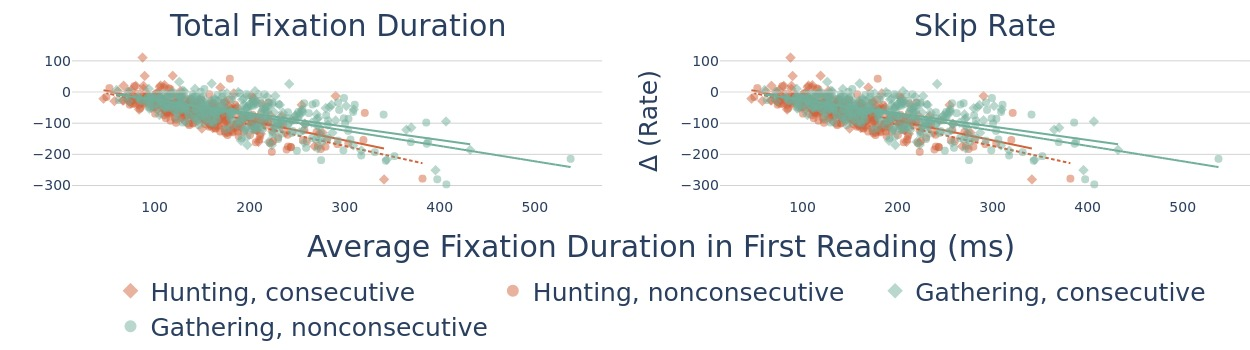

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWar

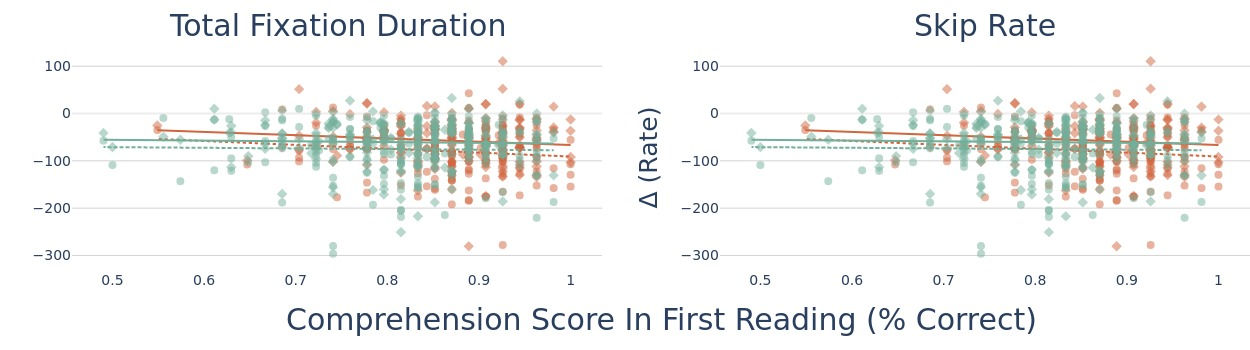

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:53: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_1702441/3307998248.py:50: UserWar

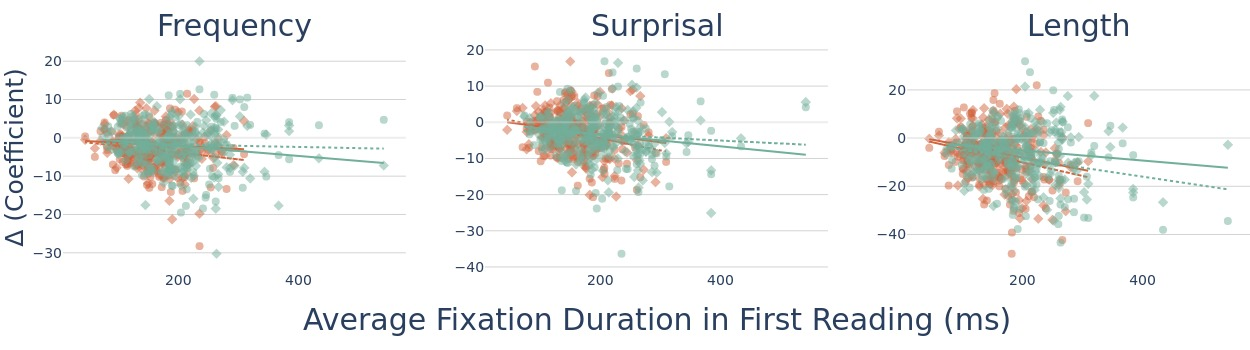

In [39]:
diff_sign = "Δ" if comparison_mode == "diff" else "Ratio"

outcome_name_mapping["Wordfreq_Frequency"] = "Frequency"
outcome_name_mapping["gpt2_Surprisal"] = "Surprisal"
outcome_name_mapping["Length"] = "Length"
outcome_name_mapping["comp_score_diff"] = (
    f"{diff_sign} Comprehension Score In Repeated Reading"
)


def plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    x_var,
    x_var_name,
    outcomes=all_outcomes,
    include_legend=True,
):
    # Create subplots with 2 rows and 3 columns
    if len(outcomes) > 3:
        fig = make_subplots(
            rows=2,
            cols=3,
            subplot_titles=[outcome_name_mapping[outcome] for outcome in outcomes],
            x_title=x_var_name,
        )
    else:
        fig = make_subplots(
            rows=1,
            cols=len(outcomes),
            subplot_titles=[outcome_name_mapping[outcome] for outcome in outcomes],
            x_title=x_var_name,
        )

    for i in fig["layout"]["annotations"]:
        i["font"] = dict(size=40)
    # Iterate over each outcome in all_outcomes
    for i, outcome in enumerate(outcomes):
        # Add a scatter plot for 'PERSONAL_RR_{outcome}_DIFF' ~ comp_score_by_RR for "Hunting"
        if outcome in all_outcomes + ["IA_DWELL_TIME"]:
            y_name = f"PERSONAL_RR_{outcome}_DIFF"
        elif outcome == "comp_score_diff":
            y_name = "comp_score_diff"
        elif outcome in ["Wordfreq_Frequency", "gpt2_Surprisal", "Length"]:
            y_name = f"Coef_{outcome}_RR_diff"

        for hp_val in ["Hunting", "Gathering"]:
            for consec_val in ["consecutive", "nonconsecutive"]:
                name = hp_val + ", " + consec_val
                col = color1 if hp_val == "Hunting" else color2
                X = personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == hp_val
                ][personal_RR_raw_RT_diff["consec_reread"] == consec_val][x_var]
                y = personal_RR_raw_RT_diff[
                    personal_RR_raw_RT_diff["has_preview"] == hp_val
                ][personal_RR_raw_RT_diff["consec_reread"] == consec_val][y_name]
                fig.add_trace(
                    go.Scatter(
                        x=X,
                        y=y,
                        mode="markers",
                        name=name,
                        marker=dict(
                            color=col,
                            symbol=(
                                "diamond" if consec_val == "consecutive" else "circle"
                            ),
                        ),  # Change color to #01895D
                        showlegend=(i == 0),  # Only show legend for the first plot
                    ),
                    row=(i // 3) + 1,
                    col=(i % 3) + 1,
                )

                model = OLS(y, add_constant(X)).fit()
                fig.add_trace(
                    go.Scatter(
                        x=X,
                        y=model.predict(),
                        mode="lines",
                        name=name,
                        line=dict(
                            color=col,
                            # set non consecutive to dashed (dots)
                            dash="dot" if consec_val == "nonconsecutive" else "solid",
                        ),  # Change color to red
                        showlegend=False,
                    ),
                    row=(i // 3) + 1,
                    col=(i % 3) + 1,
                )
                # slope_p_val_hunting = model_hunting.pvalues[1]
        fig.add_hline(
            y=0, line_color="lightgray", row=(i // 3) + 1, col=(i % 3) + 1, opacity=0.4
        )

        fig.update_traces(marker=dict(opacity=0.5))

        # update yaxis
        if comparison_mode == "diff":
            if outcome in all_outcomes and outcome not in [
                "IA_SKIP",
                "IA_RUN_COUNT",
                "IA_REGRESSION_OUT_FULL_COUNT",
            ]:
                units = "Δ (ms)"
            elif outcome == "IA_SKIP":
                units = "Δ (Rate)"
            elif outcome == "IA_RUN_COUNT":
                units = "Δ (Count)"
            elif outcome in ["Wordfreq_Frequency"]:
                units = "Δ (Coefficient)"
            elif outcome == "comp_score_diff":
                units = "Δ (% Correct)"
            else:
                units = ""
        elif comparison_mode == "ratio":
            units = "Ratio"

        fig.update_yaxes(
            title_text=units,
            row=(i // 3) + 1,
            col=(i % 3) + 1,
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )

        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

        fig.update_yaxes(
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )
        fig.update_xaxes(
            title_font=dict(size=25),
            tickfont=dict(size=14),
        )

    # change the location of the legend
    if include_legend:
        if len(outcomes) > 3:
            fig.update_layout(
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=0.35,
                    xanchor="left",
                    x=0.66,
                    # set font to 20
                    font=dict(size=25),  # Increase font size by 20
                )
            )
        else:
            fig.update_layout(
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=-1 if len(outcomes) > 1 else -1,
                    xanchor="center",
                    x=0.5,
                    font=dict(size=25),  # Increase font size by 20
                    itemsizing="constant",
                )
            )
    else:
        fig.update_layout(showlegend=False)
    # change the marker size of the legend (AND ONLY THE LEGEND)
    fig.update_traces(marker=dict(size=8))
    # change the marker size of the legend (AND ONLY THE LEGEND)
    for i in fig["layout"]["annotations"]:
        if i["text"] == x_var_name:
            i["font"] = dict(size=35)
    for i in range(len(outcomes)):
        # turn the grid background to white
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"
    fig.update_layout(
        height=350 * 1.5 if len(outcomes) > 3 else 350,
        width=1250 if len(outcomes) > 1 else 937.5,
    )

    # increse all font by 10
    fig.update_layout(font=dict(size=30))
    fig.update_annotations(font_size=30)
    # # Show the plot
    fig.update_layout(margin={"l": 0, "r": 0, "t": 45})
    fig.show(renderer="jpg")
    return fig


grt_outcomes = ["IA_DWELL_TIME", "IA_SKIP"]
# grt_outcomes = all_outcomes
TF_SR_personal_RT = plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    "PERSONAL_FR_IA_DWELL_TIME",
    "Average Fixation Duration in First Reading (ms)",
    outcomes=grt_outcomes,
    include_legend=True,
)
TF_SR_personal_comp = plot_raw_RR_FR_diff_all_outcomes(
    personal_RR_raw_RT_diff,
    "comp_score_by_RR",
    "Comprehension Score In First Reading (% Correct)",
    grt_outcomes,
    include_legend=False,
)
TF_SR_personal_RT_coefs = plot_raw_RR_FR_diff_all_outcomes(
    personal_coefs_diffs_df,
    "PERSONAL_FR_IA_DWELL_TIME",
    "Average Fixation Duration in First Reading (ms)",
    outcomes=["Wordfreq_Frequency", "gpt2_Surprisal", "Length"],
    include_legend=False,
)

In [40]:
ling_featurse_formula = """
IA_DWELL_TIME ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
    reread + sub_comp_score_FR + 
    Wordfreq_Frequency&reread + Wordfreq_Frequency&sub_comp_score_FR + Wordfreq_Frequency&reread&sub_comp_score_FR +
    gpt2_Surprisal&reread + gpt2_Surprisal&sub_comp_score_FR + gpt2_Surprisal&reread&sub_comp_score_FR +
    Length&reread + Length&sub_comp_score_FR + Length&reread&sub_comp_score_FR +
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | subject_id) + 
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | unique_paragraph_id)
""".replace("\n", "")

_, _ = run_linear_mm(
    df_input=et_data_enriched,
    outcome_variable="IA_DWELL_TIME",
    formula=ling_featurse_formula,
    re_cols=re_columns,
)

Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + reread + sub_comp_score_FR + Wordfreq_Frequency & Length + Wordfreq_Frequency & reread + Wordfreq_Frequency & sub_comp_score_FR + gpt2_Surprisal & reread + gpt2_Surprisal & sub_comp_score_FR + Length & reread + Length & sub_comp_score_FR + Wordfreq_Frequency & reread & sub_comp_score_FR + gpt2_Surprisal & reread & sub_comp_score_FR + Length & reread & sub_comp_score_FR + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | unique_paragraph_id)
     logLik       -2 logLik         AIC           AICc            BIC      
 -12200813.8780  24401627.7560  24401727.7560  24401727.7588  24402348.6008

Variance components:
                          Column         Variance   Std.Dev.   Corr.
subject_id          (Intercept)           770.40726

In [41]:
ling_featurse_formula = """
IA_DWELL_TIME ~ 1 + Wordfreq_Frequency * Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length +
    reread + sub_FR_mean_RT + 
    Wordfreq_Frequency&reread + Wordfreq_Frequency&sub_FR_mean_RT + Wordfreq_Frequency&reread&sub_FR_mean_RT +
    gpt2_Surprisal&reread + gpt2_Surprisal&sub_FR_mean_RT + gpt2_Surprisal&reread&sub_FR_mean_RT +
    Length&reread + Length&sub_FR_mean_RT + Length&reread&sub_FR_mean_RT +
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | subject_id) + 
    (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | unique_paragraph_id)
""".replace("\n", "")

_, _ = run_linear_mm(
    df_input=et_data_enriched,
    outcome_variable="IA_DWELL_TIME",
    formula=ling_featurse_formula,
    re_cols=re_columns,
)

Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + Wordfreq_Frequency + Length + gpt2_Surprisal + prev_Wordfreq_Frequency + prev_gpt2_Surprisal + prev_Length + reread + sub_FR_mean_RT + Wordfreq_Frequency & Length + Wordfreq_Frequency & reread + Wordfreq_Frequency & sub_FR_mean_RT + gpt2_Surprisal & reread + gpt2_Surprisal & sub_FR_mean_RT + Length & reread + Length & sub_FR_mean_RT + Wordfreq_Frequency & reread & sub_FR_mean_RT + gpt2_Surprisal & reread & sub_FR_mean_RT + Length & reread & sub_FR_mean_RT + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | subject_id) + (1 + Wordfreq_Frequency + gpt2_Surprisal + Length + reread | unique_paragraph_id)
     logLik       -2 logLik         AIC           AICc            BIC      
 -12199274.6872  24398549.3743  24398649.3743  24398649.3771  24399270.2190

Variance components:
                          Column         Variance   Std.Dev.   Corr.
subject_id          (Intercept)           556.45508  23.58930
          

# Other

## Comp change dist


array([[<Axes: title={'center': 'RR_score_diff'}>]], dtype=object)

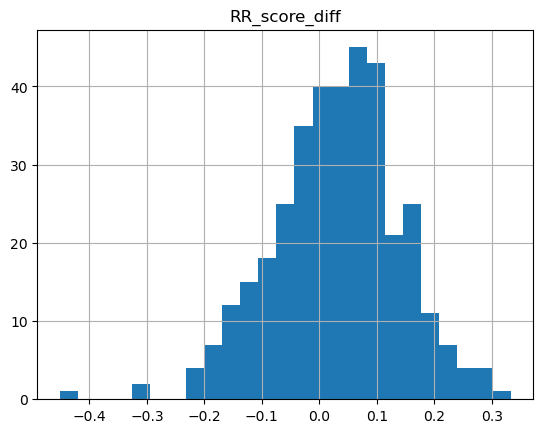

In [48]:
# for each subject_id  value hold the difference between the FR and RR scores
pivoted_scores = (
    FR_RR_compre_scores.reset_index()
    .pivot(index="subject_id", columns="reread", values="comp_score_by_RR")
    .reset_index()
)
pivoted_scores["RR_score_diff"] = pivoted_scores[1] - pivoted_scores[0]
pivoted_scores[["subject_id", "RR_score_diff"]].hist(bins=25)

## Question level cmprehension score means


In [61]:
print("Gathering::::")
comp_out = run_linear_mm(
    df_input=et_data_enriched.query("has_preview == 'Gathering'")[
        ["unique_paragraph_id", "subject_id", "is_correct", "reread"]
    ].drop_duplicates(),
    outcome_variable="is_correct",
    re_cols=["subject_id", "unique_paragraph_id"],
    formula="is_correct ~ reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)",
)

print("Hunting::::")
comp_out = run_linear_mm(
    df_input=et_data_enriched.query("has_preview == 'Hunting'")[
        ["unique_paragraph_id", "subject_id", "is_correct", "reread"]
    ].drop_duplicates(),
    outcome_variable="is_correct",
    re_cols=["subject_id", "unique_paragraph_id"],
    formula="is_correct ~ reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)",
)

print("Hunting:::: RR - same CS vs diff CS")
comp_out = run_linear_mm(
    df_input=et_data_enriched.query("has_preview == 'Hunting' and reread == 1")[
        ["unique_paragraph_id", "subject_id", "is_correct", "same_span_in_FR"]
    ].drop_duplicates(),
    outcome_variable="is_correct",
    re_cols=["subject_id", "unique_paragraph_id"],
    formula="is_correct ~ same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)",
)

Gathering::::
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)
   logLik   -2 logLik     AIC       AICc        BIC    
 -5136.3927 10272.7854 10290.7854 10290.8009 10357.0142

Variance components:
                       Column    Variance   Std.Dev.    Corr.
unique_paragraph_id (Intercept)  0.00917011 0.09576068
                    reread       0.00007492 0.00865552 -1.00
subject_id          (Intercept)  0.00574678 0.07580750
                    reread       0.00000192 0.00138498 -1.00
Residual                         0.13449064 0.36672965
 Number of obs: 11600; levels of grouping factors: 324, 180

  Fixed-effects parameters:
───────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────────────────────────────
(Intercept)  0.812332   0.00861254  94.32    <1e-99
reread       0.0288963  0.00916402   3.15    0.0016
────

## Corect ~ article ind


In [60]:
q_correct_df = et_data_enriched[
    [
        "subject_id",
        "unique_paragraph_id",
        "reread",
        "article_ind",
        "is_correct",
    ]
].drop_duplicates()

In [56]:
means = calc_mm_means_for_all_outcomes(
    q_correct_df.query("article_ind <= 10"),
    ["article_ind"],
    re_columns,
    ["is_correct"],
    mean_mode="subset_mean",
)

outcome_variable: is_correct
df_m shape before dropping nan: (19360, 6)
df_m shape after dropping nan: (19360, 6)
u_vals: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


In [57]:
# make means['article_ind] numerical
means["article_ind"] = means["article_ind"].astype(int)

In [58]:
# Add a slope line (use linear mm for that)
is_correct_lmm = run_linear_mm(
    df_input=q_correct_df.query("article_ind <= 10"),
    outcome_variable="is_correct",
    re_cols=re_columns,
    formula="is_correct ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)",
    # link_dist=Bernoulli()
)

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 is_correct ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
   logLik   -2 logLik     AIC       AICc        BIC    
 -7524.6201 15049.2402 15067.2402 15067.2495 15138.0789

Variance components:
                       Column    Variance   Std.Dev.    Corr.
subject_id          (Intercept)  0.00683006 0.08264419
                    article_ind  0.00002707 0.00520270 -0.50
unique_paragraph_id (Intercept)  0.00907956 0.09528673
                    article_ind  0.00002742 0.00523594 -0.58
Residual                         0.12116710 0.34809065
 Number of obs: 19360; levels of grouping factors: 360, 324

  Fixed-effects parameters:
─────────────────────────────────────────────────────
                  Coef.   Std. Error      z  Pr(>|z|)
─────────────────────────────────────────────────────
(Intercept)  0.832029    0.00876914   94.88    <1e-99
article_ind  0.00161848  0.000967528   1.67    

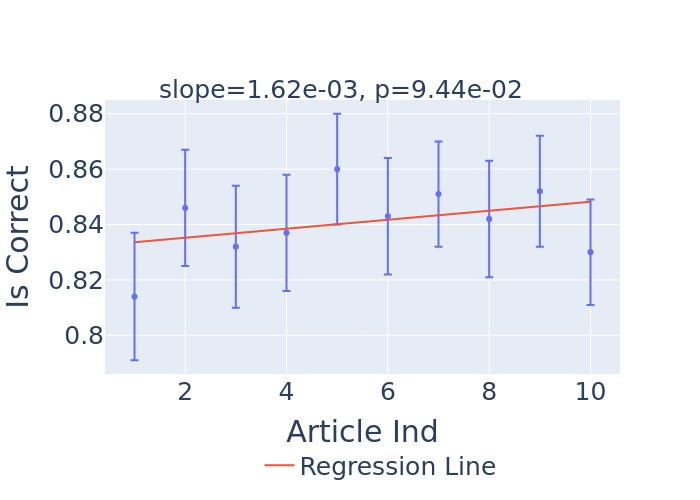

In [59]:
# Createe a graph starting from 0 od mean as a function of article ind with 2se as error bars (use plotly)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=means["article_ind"],
        y=means["mean"],
        error_y=dict(
            type="data",
            symmetric=True,
            array=means["2se"],
            # thickness=5,
            # width=10,
        ),
        mode="markers",
        showlegend=False,
    )
)

fig.update_xaxes(title_text="Article Ind", tickfont=dict(size=25))

fig.update_yaxes(title_text="Is Correct", tickfont=dict(size=25))

fig.update_layout(
    # font
    font=dict(size=25),
    titlefont=dict(size=40),
)
# fig.update_yaxes(rangemode="tozero")

# add a line with itercept is_correct_lmm[0]['(Intercept)'] and slope is_correct_lmm[0]['article_ind']
fig.add_trace(
    go.Scatter(
        x=means["article_ind"],
        y=is_correct_lmm[0].iloc[0]["Coef."]
        + is_correct_lmm[0].iloc[1]["Coef."] * means["article_ind"],
        mode="lines",
        name="Regression Line",
    )
)

# Add the slope (is_correct_lmm[0].iloc[0]['Coef.']) and p-value (is_correct_lmm[0].iloc[0]['Pr(>|z|)']) to the top left corner
fig.add_annotation(
    dict(
        font=dict(size=25),
        x=0.1,
        y=1.1,
        showarrow=False,
        text=f"slope={is_correct_lmm[0].iloc[1]['Coef.']:.2e}, p={is_correct_lmm[0].iloc[1]['Pr(>|z|)']:.2e}",
        xref="paper",
        yref="paper",
    )
)

# move the legend to the bottom
fig = fig.update_layout(legend=dict(orientation="h", title="", y=-0.25, x=0.3))
# make y start form 0

fig.show(renderer="jpg")